# Drone Search Path Demo

This notebook lets you experiment with a **search path generator** on a mountain height matrix `H`.

You can replace the example `H` with your own 7×7 / 10×10 / 15×15 matrix.

Main functions:
- `compute_visible_set(H, x0, y0, vis_dist)` – points within visibility distance
- `generate_search_path_greedy(H, vis_dist, safe_margin)` – greedy coverage search path

At the bottom there is a simple visualization using `matplotlib`.

In [5]:
# Imports
import numpy as np
import math
import matplotlib.pyplot as plt

# ==========================================
# 1. Define your mountain matrix H here
# ==========================================
# You can replace this example with your own matrix.
# Example 7x7 matrix with several peaks and valleys:
H = np.array([
    [1, 1, 1, 1, 0, 0, 0],
    [4, 4, 2, 0, 1, 3, 3],
    [4, 7, 2, 0, 1, 6, 3],
    [4, 4, 2, 0, 1, 3, 3],
    [1, 1, 2, 2, 2, 0, 0],
    [0, 0, 2, 5, 2, 0, 0],
    [0, 0, 2, 2, 2, 0, 0]
], dtype=int)

n_rows, n_cols = H.shape
print("Matrix shape:", H.shape)
H

Matrix shape: (7, 7)


array([[1, 1, 1, 1, 0, 0, 0],
       [4, 4, 2, 0, 1, 3, 3],
       [4, 7, 2, 0, 1, 6, 3],
       [4, 4, 2, 0, 1, 3, 3],
       [1, 1, 2, 2, 2, 0, 0],
       [0, 0, 2, 5, 2, 0, 0],
       [0, 0, 2, 2, 2, 0, 0]])

In [6]:
# ==========================================
# 2. Visibility and greedy search path
# ==========================================
def compute_visible_set(H, x0, y0, vis_dist):
    """Return set of (x,y) indices whose 3D distance to (x0,y0,z0)
    is <= vis_dist. Here z0 = H[x0,y0]. We **ignore terrain occlusion**
    for now and only use distance.
    """
    n_rows, n_cols = H.shape
    z0 = H[x0, y0]
    visible = set()
    for x in range(n_rows):
        for y in range(n_cols):
            z = H[x, y]
            dx = x - x0
            dy = y - y0
            dz = z - z0
            d = math.sqrt(dx*dx + dy*dy + dz*dz)
            if d <= vis_dist:
                visible.add((x, y))
    return visible

def generate_search_path_greedy(H, vis_dist=3.0, safe_margin=1.0):
    """Greedy search path generator.

    U = all surface points (x,y) not yet covered.
    Each step, pick the point that covers the maximum number of
    uncovered points within visibility distance.

    Returns:
        path: list of dicts with keys 'x','y','z'
    """
    n_rows, n_cols = H.shape
    U = {(x, y) for x in range(n_rows) for y in range(n_cols)}
    path = []

    step_idx = 0
    while U:
        best_point = None
        best_cover = set()

        for x in range(n_rows):
            for y in range(n_cols):
                cand_visible = compute_visible_set(H, x, y, vis_dist)
                cover = cand_visible & U
                if len(cover) > len(best_cover):
                    best_cover = cover
                    best_point = (x, y)

        if best_point is None:
            # Should not happen, but just in case
            break

        x_best, y_best = best_point
        z_best = H[x_best, y_best] + safe_margin
        path.append({"x": x_best, "y": y_best, "z": float(z_best)})
        U -= best_cover
        step_idx += 1
        # Debug print
        print(f"Step {step_idx}: choose ({x_best},{y_best}), new uncovered = {len(U)}")

    return path


In [7]:
# ==========================================
# 3. Run the greedy search path on the matrix
# ==========================================
vis_dist = 4.0   # you can adjust this
safe_margin = 1.0

path = generate_search_path_greedy(H, vis_dist=vis_dist, safe_margin=safe_margin)
print("\nFinal path (x,y,z):")
for i, p in enumerate(path):
    print(i, p)


Step 1: choose (3,2), new uncovered = 14
Step 2: choose (3,4), new uncovered = 3
Step 3: choose (1,0), new uncovered = 2
Step 4: choose (1,5), new uncovered = 1
Step 5: choose (4,0), new uncovered = 0

Final path (x,y,z):
0 {'x': 3, 'y': 2, 'z': 3.0}
1 {'x': 3, 'y': 4, 'z': 2.0}
2 {'x': 1, 'y': 0, 'z': 5.0}
3 {'x': 1, 'y': 5, 'z': 4.0}
4 {'x': 4, 'y': 0, 'z': 2.0}


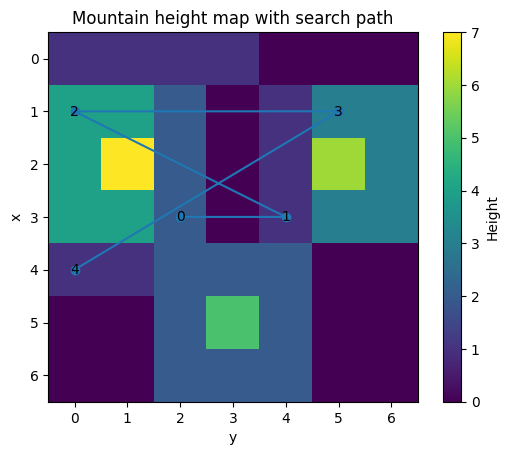

In [8]:
# ==========================================
# 4. Simple visualization
# ==========================================
fig, ax = plt.subplots()
im = ax.imshow(H)
plt.colorbar(im, ax=ax, label="Height")

# Overlay path indices
xs = [p['y'] for p in path]  # note: imshow uses (row=y, col=x) convention visually
ys = [p['x'] for p in path]
ax.plot(xs, ys, marker='o')

for i, (x, y) in enumerate(zip(xs, ys)):
    ax.text(x, y, str(i), ha='center', va='center')

ax.set_title("Mountain height map with search path")
ax.set_xlabel("y")
ax.set_ylabel("x")
plt.show()


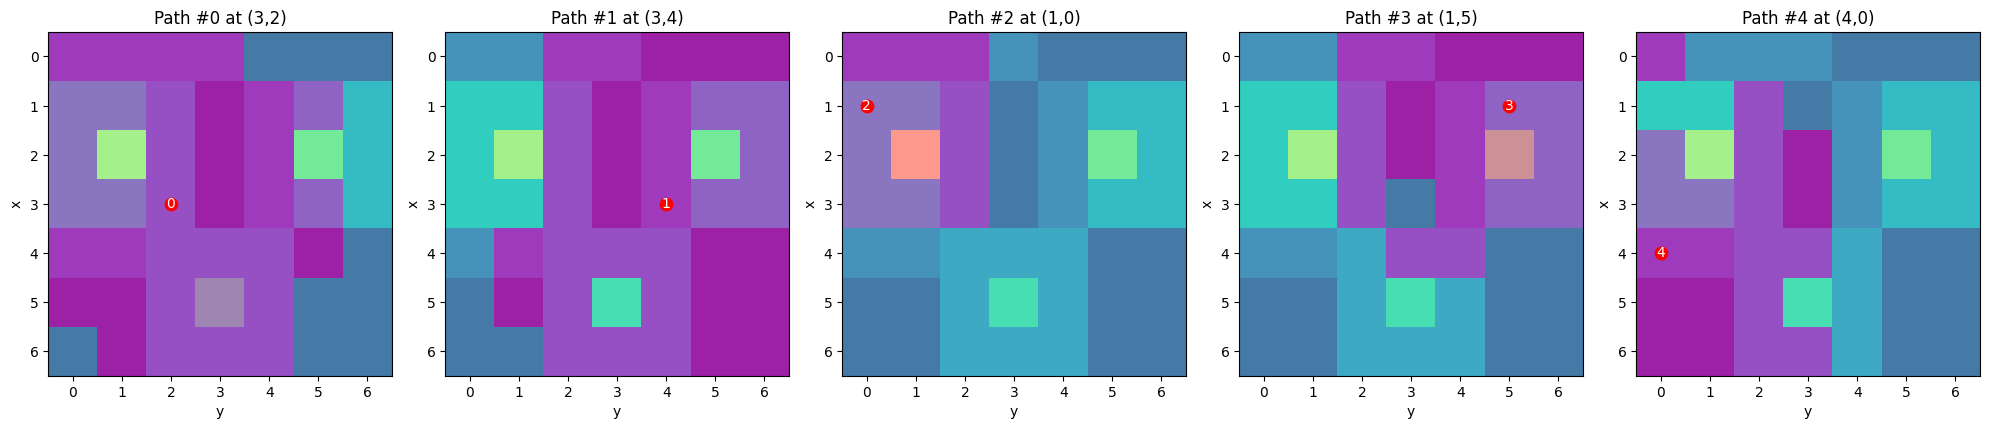

In [9]:
# ==========================================
# 5. Visualize visibility for each path point
# ==========================================
fig, axs = plt.subplots(1, len(path), figsize=(4 * len(path), 4))

if len(path) == 1:
    axs = [axs]

for i, p in enumerate(path):
    x0, y0 = p["x"], p["y"]
    z0 = p["z"]

    # 计算可见点集合
    visible = compute_visible_set(H, x0, y0, vis_dist)

    # 转换为 mask
    mask = np.zeros_like(H, dtype=float)
    for (x, y) in visible:
        mask[x, y] = 1.0

    ax = axs[i]
    ax.set_title(f"Path #{i} at ({x0},{y0})")

    # 绘制高度图
    im = ax.imshow(H, alpha=0.8)

    # 绘制 visibility mask（半透明）
    ax.imshow(mask, alpha=0.35, cmap="cool")

    # 标注观察点
    ax.scatter([y0], [x0], c="red", s=80, marker="o")
    ax.text(y0, x0, f"{i}", color="white", ha="center", va="center")

    ax.set_xlabel("y")
    ax.set_ylabel("x")

plt.tight_layout()
plt.show()
